In [1]:
import numpy as np
import numpy.matlib as mt
import h5py
import math 
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials import align_trials
from ephysvibe.task import task_constants

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy import signal,stats

import os 
from matplotlib import cm
from matplotlib import pyplot as plt
import glob
from pathlib import Path
import pickle

from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import permutations
seed = 2023


In [2]:
def pick_train_test_trials(trials, train_ratio):
    tmp     =   np.random.permutation(trials)
    train   =   tmp[:int((trials.shape[0]*train_ratio))]
    test    =   tmp[int((trials.shape[0]*train_ratio)):]

    train_rep   =   mt.repmat(train, test.shape[0],1)
    test_rep    =   mt.repmat(test, train.shape[0],1)
    if np.where(test_rep-np.transpose(train_rep)==0)[0].shape[0]!=0:
        print("Warnings: similar trials for training and testing")

    return train, test


In [49]:

def get_cond(test_data):
    # basic conditions
    s_in_11_t_11= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==11), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_15_t_11= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==11), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_51_t_11= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==11), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_55_t_11= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==11), test_data['sample pos']==1), test_data['test num']>0))[0]

    s_in_11_t_15= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==15), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_15_t_15= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==15), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_51_t_15= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==15), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_55_t_15= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==15), test_data['sample pos']==1), test_data['test num']>0))[0]

    s_in_11_t_51= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==51), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_15_t_51= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==51), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_51_t_51= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==51), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_55_t_51= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==51), test_data['sample pos']==1), test_data['test num']>0))[0]

    s_in_11_t_55= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==55), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_15_t_55= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==55), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_51_t_55= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==55), test_data['sample pos']==1), test_data['test num']>0))[0]
    s_in_55_t_55= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==55), test_data['sample pos']==1), test_data['test num']>0))[0]

    s_out_11_t_11= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==11), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_15_t_11= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==11), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_51_t_11= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==11), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_55_t_11= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==11), test_data['sample pos']==-1), test_data['test num']>0))[0]

    s_out_11_t_15= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==15), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_15_t_15= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==15), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_51_t_15= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==15), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_55_t_15= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==15), test_data['sample pos']==-1), test_data['test num']>0))[0]

    s_out_11_t_51= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==51), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_15_t_51= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==51), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_51_t_51= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==51), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_55_t_51= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==51), test_data['sample pos']==-1), test_data['test num']>0))[0]

    s_out_11_t_55= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==55), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_15_t_55= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==55), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_51_t_55= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==55), test_data['sample pos']==-1), test_data['test num']>0))[0]
    s_out_55_t_55= np.where(np.logical_and(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==55), test_data['sample pos']==-1), test_data['test num']>0))[0]

    basic_cond=  np.array([s_in_11_t_11.shape[0],  s_in_11_t_15.shape[0], s_in_11_t_51.shape[0], s_in_11_t_55.shape[0],
                s_in_15_t_11.shape[0], s_in_15_t_15.shape[0], s_in_15_t_51.shape[0], s_in_15_t_55.shape[0],
                s_in_51_t_11.shape[0], s_in_51_t_15.shape[0], s_in_51_t_51.shape[0], s_in_51_t_55.shape[0],
                s_in_55_t_11.shape[0], s_in_55_t_15.shape[0], s_in_55_t_51.shape[0], s_in_55_t_55.shape[0]])
    
    trials_s_in_t_11 =   np.where(np.logical_and(np.logical_and(test_data['sample id']!=0, test_data['test id']==11), test_data['sample pos']==1))[0]
    trials_s_in_t_15 =   np.where(np.logical_and(np.logical_and(test_data['sample id']!=0, test_data['test id']==15), test_data['sample pos']==1))[0]
    trials_s_in_t_51 =   np.where(np.logical_and(np.logical_and(test_data['sample id']!=0, test_data['test id']==51), test_data['sample pos']==1))[0]
    trials_s_in_t_55 =   np.where(np.logical_and(np.logical_and(test_data['sample id']!=0, test_data['test id']==55), test_data['sample pos']==1))[0]

    trials_s_out_t_11    =   np.where(np.logical_and(np.logical_and(test_data['sample id']!=0, test_data['test id']==11), test_data['sample pos']==-1))[0]
    trials_s_out_t_15    =   np.where(np.logical_and(np.logical_and(test_data['sample id']!=0, test_data['test id']==15), test_data['sample pos']==-1))[0]
    trials_s_out_t_51    =   np.where(np.logical_and(np.logical_and(test_data['sample id']!=0, test_data['test id']==51), test_data['sample pos']==-1))[0]
    trials_s_out_t_55    =   np.where(np.logical_and(np.logical_and(test_data['sample id']!=0, test_data['test id']==55), test_data['sample pos']==-1))[0]


    num_s_in_11_match    =   s_in_11_t_11.shape[0]
    num_s_in_15_match    =   s_in_15_t_15.shape[0]
    num_s_in_51_match    =   s_in_51_t_51.shape[0]
    num_s_in_55_match    =   s_in_55_t_55.shape[0]

    num_s_in_11_nomatch    =   np.concatenate([s_in_11_t_15, s_in_11_t_51, s_in_11_t_55]).shape[0]
    num_s_in_15_nomatch    =   np.concatenate([s_in_15_t_11, s_in_15_t_51, s_in_15_t_55]).shape[0]
    num_s_in_51_nomatch    =   np.concatenate([s_in_51_t_11, s_in_51_t_15, s_in_51_t_55]).shape[0]
    num_s_in_55_nomatch    =   np.concatenate([s_in_55_t_11, s_in_55_t_15, s_in_55_t_51]).shape[0]
    
    num_11  =   np.min([num_s_in_11_match, num_s_in_11_nomatch])
    num_15  =   np.min([num_s_in_15_match, num_s_in_15_nomatch])
    num_51  =   np.min([num_s_in_51_match, num_s_in_51_nomatch])
    num_55  =   np.min([num_s_in_55_match, num_s_in_55_nomatch])
    
    s_in_11_nomatch     =    np.random.permutation(np.concatenate([s_in_11_t_15, s_in_11_t_51, s_in_11_t_55]))[:num_11]
    s_in_15_nomatch     =    np.random.permutation(np.concatenate([s_in_15_t_11, s_in_15_t_51, s_in_15_t_55]))[:num_15]
    s_in_51_nomatch     =    np.random.permutation(np.concatenate([s_in_51_t_11, s_in_51_t_15, s_in_51_t_55]))[:num_51]
    s_in_55_nomatch     =    np.random.permutation(np.concatenate([s_in_55_t_11, s_in_55_t_15, s_in_55_t_51]))[:num_55]

    trials_s_in_t_nomatch   =   np.concatenate([s_in_11_nomatch, s_in_15_nomatch, s_in_51_nomatch, s_in_55_nomatch])

    trials_s_in_t_match     =   np.concatenate([np.random.permutation(s_in_11_t_11)[:num_11], 
                                                np.random.permutation(s_in_15_t_15)[:num_15], 
                                                np.random.permutation(s_in_51_t_51)[:num_51], 
                                                np.random.permutation(s_in_55_t_55)[:num_55]])

    num_s_11_nomatch    =   np.concatenate([s_out_11_t_15, s_out_11_t_51, s_out_11_t_55]).shape[0]
    num_s_15_nomatch    =   np.concatenate([s_out_15_t_11, s_out_15_t_51, s_out_15_t_55]).shape[0]
    num_s_51_nomatch    =   np.concatenate([s_out_51_t_11, s_out_51_t_15, s_out_51_t_55]).shape[0]
    num_s_55_nomatch    =   np.concatenate([s_out_55_t_11, s_out_55_t_15, s_out_55_t_51]).shape[0]

    
    trials_s_out_t_match     =   np.concatenate([np.random.permutation(s_out_11_t_11)[:num_s_11_nomatch], 
                                                np.random.permutation(s_out_15_t_15)[:num_s_15_nomatch], 
                                                np.random.permutation(s_out_51_t_51)[:num_s_51_nomatch], 
                                                np.random.permutation(s_out_55_t_55)[:num_s_55_nomatch]])

    trials_s_out_t_nomatch   =   np.concatenate([s_out_15_t_11, s_out_51_t_11, s_out_55_t_11, 
                                                s_out_11_t_15, s_out_51_t_15, s_out_55_t_15, 
                                                s_out_11_t_51, s_out_15_t_51, s_out_55_t_51, 
                                                s_out_11_t_55, s_out_15_t_55, s_out_51_t_55])


    trials_s_bar_release    =   np.concatenate([trials_s_in_t_match, trials_s_out_t_match])
    trials_s_hold_bar       =   np.concatenate([trials_s_in_t_nomatch, trials_s_out_t_nomatch])

    return {'basic':basic_cond,
            'num_s_11_nomatch': num_s_in_11_nomatch,
            'num_s_15_nomatch': num_s_in_15_nomatch,
            'num_s_51_nomatch': num_s_in_51_nomatch,
            'num_s_55_nomatch': num_s_in_55_nomatch,
            's in t 11': trials_s_in_t_11,
            's in t 15': trials_s_in_t_15,
            's in t 51': trials_s_in_t_51,
            's in t 55': trials_s_in_t_55,
            's out t 11': trials_s_out_t_11,
            's out t 15': trials_s_out_t_15,
            's out t 51': trials_s_out_t_51,
            's out t 55': trials_s_out_t_55,
            's in t match': trials_s_in_t_match,
            's in t nomatch': trials_s_in_t_nomatch,
            's out t match': trials_s_out_t_match,
            's out t nomatch': trials_s_out_t_nomatch,
            'bar release': trials_s_bar_release, 
            'hold bar': trials_s_hold_bar}


In [4]:
model=  SVC(kernel='linear',C=10 ,decision_function_shape='ovr',gamma='auto',degree=1)

In [50]:

def decode_test_par(dat):
    num_train   =   40
    num_test    =   10
    test_train_ratio    =   1-num_test/num_train

    cond=[]
    sel_cells=[]    
    for i in range(len(dat)):
        tmp=get_cond(dat[i])  
        cond.append(tmp)
        if np.min(np.concatenate([tmp['s in t 11'].shape, tmp['s in t 15'].shape, 
                                  tmp['s in t 51'].shape, tmp['s in t 55'].shape, 
                                  tmp['s in t match'].shape, tmp['s in t nomatch'].shape,
                                    tmp['s out t 11'].shape, tmp['s in t 15'].shape,
                                    tmp['s out t 51'].shape, tmp['s out t 55'].shape, 
                                    tmp['s out t match'].shape, tmp['s out t nomatch'].shape]))>50:
        # if np.min([tmp['num_s_11_nomatch'],tmp['num_s_15_nomatch'],tmp['num_s_51_nomatch'],tmp['num_s_55_nomatch']])>=20:
            sel_cells.append(i)
            

    num_cells   =   len(sel_cells)
    sel_cells   =   np.array(sel_cells)[np.random.permutation(num_cells)]#[:300]

    names       =   list(dat[i]['name'] for i in sel_cells)
    if 'averaged data' in dat[i].keys():
        datas       =   list(dat[i]['averaged data'] for i in sel_cells)
    elif 'zscored data' in dat[i].keys():
        datas       =   list(dat[i]['zscored data'] for i in sel_cells)

    cond        =   list(cond[i] for i in sel_cells)

    data_train_id_in    =   np.empty([datas[0].shape[1], num_train*4, num_cells])
    data_train_id_out   =   np.empty([datas[0].shape[1], num_train*4, num_cells])
    data_train_match_in =   np.empty([datas[0].shape[1], num_train*2, num_cells])
    data_train_match_out=   np.empty([datas[0].shape[1], num_train*2, num_cells])
    data_train_bar      =   np.empty([datas[0].shape[1], num_train*2, num_cells])

    data_test_id_in    =   np.empty([datas[0].shape[1], num_test*4, num_cells])
    data_test_id_out   =   np.empty([datas[0].shape[1], num_test*4, num_cells])
    data_test_match_in =   np.empty([datas[0].shape[1], num_test*2, num_cells])
    data_test_match_out=   np.empty([datas[0].shape[1], num_test*2, num_cells])
    data_test_bar      =   np.empty([datas[0].shape[1], num_test*2, num_cells])

    y_train_id  =   np.concatenate([np.zeros(num_train), np.ones(num_train), np.zeros(num_train)+2, np.ones(num_train)+2])
    y_test_id   =   np.concatenate([np.zeros(num_test), np.ones(num_test), np.zeros(num_test)+2, np.ones(num_test)+2])

    y_train_match=   np.concatenate([np.zeros(num_train), np.ones(num_train)])
    y_test_match =   np.concatenate([np.zeros(num_test), np.ones(num_test)])

    perf_id_in          =   np.empty([len(data_train_id_in)])
    perf_id_out         =   np.empty([len(data_train_id_out)])    
    perf_match_in       =   np.empty([len(data_train_match_in)])
    perf_match_out      =   np.empty([len(data_train_match_out)])
    perf_bar            =   np.empty([len(data_train_bar)])
    perf_match_train_in_test_out=   np.empty([len(data_train_bar)])
    perf_match_train_out_test_in=   np.empty([len(data_train_bar)])

    for cell in range(len(sel_cells)):
        # id trials in
        train_11_in, test_11_in =   pick_train_test_trials(cond[cell]['s in t 11'], test_train_ratio)
        train_15_in, test_15_in =   pick_train_test_trials(cond[cell]['s in t 15'], test_train_ratio)
        train_51_in, test_51_in =   pick_train_test_trials(cond[cell]['s in t 51'], test_train_ratio)
        train_55_in, test_55_in =   pick_train_test_trials(cond[cell]['s in t 55'], test_train_ratio)

        trials_train_id_in      =   np.concatenate([np.random.choice(train_11_in, num_train),
                                                    np.random.choice(train_15_in, num_train),
                                                    np.random.choice(train_51_in, num_train),
                                                    np.random.choice(train_55_in, num_train)])
        
        trials_test_id_in  =   np.concatenate([np.random.choice(test_11_in, num_test),
                                                np.random.choice(test_15_in, num_test),
                                                np.random.choice(test_51_in, num_test),
                                                np.random.choice(test_55_in, num_test),])
        
        # id trials out
        train_11_out, test_11_out   =  pick_train_test_trials(cond[cell]['s out t 11'], test_train_ratio)
        train_15_out, test_15_out   =  pick_train_test_trials(cond[cell]['s out t 15'], test_train_ratio)
        train_51_out, test_51_out   =  pick_train_test_trials(cond[cell]['s out t 51'], test_train_ratio)
        train_55_out, test_55_out   =  pick_train_test_trials(cond[cell]['s out t 55'], test_train_ratio)
        trials_train_id_out =   np.concatenate([np.random.choice(train_11_out, num_train),
                                                np.random.choice(train_15_out, num_train),
                                                np.random.choice(train_51_out, num_train),
                                                np.random.choice(train_55_out, num_train)])
        trials_test_id_out  =   np.concatenate([np.random.choice(test_11_out, num_test),
                                                np.random.choice(test_15_out, num_test),
                                                np.random.choice(test_51_out, num_test),
                                                np.random.choice(test_55_out, num_test),])
        # match trials in
        train_match_in, test_match_in   =   pick_train_test_trials(cond[cell]['s in t match'], test_train_ratio)
        train_nomatch_in, test_nomatch_in =  pick_train_test_trials(cond[cell]['s in t nomatch'], test_train_ratio)
        trials_train_match_in   =   np.concatenate([np.random.choice(train_match_in, num_train),
                                                np.random.choice(train_nomatch_in, num_train)])
        trials_test_match_in    =   np.concatenate([np.random.choice(test_match_in, num_test),
                                                np.random.choice(test_nomatch_in, num_test)])
        
        # match trials out
        train_match_out, test_match_out =  pick_train_test_trials(cond[cell]['s out t match'], test_train_ratio)
        train_nomatch_out, test_nomatch_out =  pick_train_test_trials(cond[cell]['s out t nomatch'], test_train_ratio)
        trials_train_match_out  =   np.concatenate([np.random.choice(train_match_out, num_train),
                                                np.random.choice(train_nomatch_out, num_train)])
        trials_test_match_out   =   np.concatenate([np.random.choice(test_match_out, num_test),
                                                np.random.choice(test_nomatch_out, num_test)])
                
        # bar release
        train_bar, test_bar =  pick_train_test_trials(cond[cell]['bar release'], test_train_ratio)
        train_nobar, test_nobar =  pick_train_test_trials(cond[cell]['hold bar'], test_train_ratio)
        trials_train_bar    =   np.concatenate([np.random.choice(train_bar, num_train),
                                                np.random.choice(train_nobar, num_train)])
        trials_test_bar     =   np.concatenate([np.random.choice(test_bar, num_test),
                                                np.random.choice(test_nobar, num_test)])
                
        # build matrices of  [timestamp, trials, neurons] dimensions to feed to classifiers
        
        data_train_id_in[:, :, cell]        =   np.transpose(datas[cell][trials_train_id_in])
        data_train_id_out[:, :, cell]       =   np.transpose(datas[cell][trials_train_id_out])
        data_train_match_in[:, :, cell]     =   np.transpose(datas[cell][trials_train_match_in])
        data_train_match_out[:, :, cell]    =   np.transpose(datas[cell][trials_train_match_out])   
        data_train_bar[:, :, cell]          =   np.transpose(datas[cell][trials_train_bar])
        
        data_test_id_in[:, :, cell]         =   np.transpose(datas[cell][trials_test_id_in])
        data_test_id_out[:, :, cell]        =   np.transpose(datas[cell][trials_test_id_out])
        data_test_match_in[:, :, cell]      =   np.transpose(datas[cell][trials_test_match_in])
        data_test_match_out[:, :, cell]     =   np.transpose(datas[cell][trials_test_match_out])        
        data_test_bar[:, :, cell]           =   np.transpose(datas[cell][trials_test_bar])

    for time_train in range(data_train_id_in.shape[0]):
        model.fit(data_train_id_in[time_train],y_train_id)
        y_predict = model.predict(data_test_id_in[time_train])
        perf_id_in[time_train]=np.where(y_predict-y_test_id==0)[0].shape[0]

        model.fit(data_train_id_out[time_train],y_train_id)
        y_predict = model.predict(data_test_id_out[time_train])
        perf_id_out[time_train]=np.where(y_predict-y_test_id==0)[0].shape[0]

        model.fit(data_train_match_in[time_train],y_train_match)
        y_predict = model.predict(data_test_match_in[time_train])
        perf_match_in[time_train]=np.where(y_predict-y_test_match==0)[0].shape[0]

        model.fit(data_train_match_out[time_train],y_train_match)
        y_predict = model.predict(data_test_match_out[time_train])
        perf_match_out[time_train]=np.where(y_predict-y_test_match==0)[0].shape[0]

        model.fit(data_train_match_in[time_train],y_train_match)
        y_predict = model.predict(data_test_match_out[time_train])
        perf_match_train_in_test_out[time_train]=np.where(y_predict-y_test_match==0)[0].shape[0]
        
        model.fit(data_train_match_out[time_train],y_train_match)
        y_predict = model.predict(data_test_match_in[time_train])
        perf_match_train_out_test_in[time_train]=np.where(y_predict-y_test_match==0)[0].shape[0]


        model.fit(data_train_bar[time_train],y_train_match)
        y_predict = model.predict(data_test_bar[time_train])
        perf_bar[time_train]=np.where(y_predict-y_test_match==0)[0].shape[0]

    return{'lip num cells': len(sel_cells),
           'perf id in': perf_id_in,
           'perf id out': perf_id_out,
           'perf match in': perf_match_in,
           'perf match out': perf_match_out,
           'perf x match in_out': perf_match_train_in_test_out,
           'perf x match out_in': perf_match_train_out_test_in,
           'perf bar': perf_bar}



In [11]:
def reorganize_data(data, num_iter):
    p_test_id_in    =   np.empty([num_iter, data[0]['perf id in'].shape[0]])*np.nan
    p_test_id_out   =   np.empty([num_iter, data[0]['perf id out'].shape[0]])*np.nan
    p_test_match_in =   np.empty([num_iter, data[0]['perf match in'].shape[0]])*np.nan
    p_test_match_out=   np.empty([num_iter, data[0]['perf match out'].shape[0]])*np.nan
    p_test_xmatch_inout =   np.empty([num_iter, data[0]['perf x match in_out'].shape[0]])*np.nan
    p_test_xmatch_outin =   np.empty([num_iter, data[0]['perf x match out_in'].shape[0]])*np.nan
    p_test_bar      =   np.empty([num_iter, data[0]['perf bar'].shape[0]])*np.nan

    for i in range(num_iter):
        p_test_id_in[i,:]       =   data[i]['perf id in']
        p_test_id_out[i,:]      =   data[i]['perf id out']
        p_test_match_in[i,:]    =   data[i]['perf match in']
        p_test_match_out[i,:]   =   data[i]['perf match out']
        p_test_xmatch_inout[i,:]    =   data[i]['perf x match in_out']
        p_test_xmatch_outin[i,:]    =   data[i]['perf x match out_in']
        p_test_bar[i,:]         =   data[i]['perf bar']
    
    return {'perf id in':p_test_id_in,
            'perf id out':p_test_id_out,
            'perf match in':p_test_match_in,
            'perf match out':p_test_match_out,
            'perf xmatch inout':p_test_xmatch_inout,
            'perf xmatch outin':p_test_xmatch_outin,
            'perf bar':p_test_bar}
    

In [27]:
with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/lip_test_zsc_w100_s5m300p500', 'rb') as handle:
    test_lip_zsc = pickle.load(handle)
    
with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/pfc_test_zsc_w100_s5m300p500', 'rb') as handle:
    test_pfc_zsc = pickle.load(handle)
    
with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/v4_test_zsc_w100_s5m300p500', 'rb') as handle:
    test_v4_zsc = pickle.load(handle)
# with open('envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/lip_test_zsc', 'rb') as handle:
#     test_lip_zsc = pickle.load(handle)

# with open('envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/lip_test_cond', 'rb') as handle:
#     test_lip_cond = pickle.load(handle)


# with open(r'W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/pfc_test_zsc', 'rb') as handle:
#     test_pfc_zsc = pickle.load(handle)
    
# with open('envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/pfc_test_zsc', 'rb') as handle:
#     test_pfc_zsc = pickle.load(handle)

# with open('envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/pfc_test_cond', 'rb') as handle:
#     test_pfc_cond = pickle.load(handle)


# with open('envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/v4_test_zsc', 'rb') as handle:
#     test_v4_zsc = pickle.load(handle)
    
# with open('envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/v4_test_zsc', 'rb') as handle:
#     test_v4_zsc = pickle.load(handle)

# with open('envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/v4_test_cond', 'rb') as handle:
#     test_v4_cond = pickle.load(handle)

In [29]:
do_lip=1
do_pfc=1
do_v4=1
num_iter=10

In [40]:
test_lip_zsc[0]['test num']

array([0., 0., 0., ..., 4., 4., 4.])

In [51]:

if do_lip==1:
        perf    =   Parallel(n_jobs = -1)(delayed(decode_test_par)(test_lip_zsc) for cell in tqdm(range(num_iter)))
        perf_decoding_lip=reorganize_data(perf, num_iter)
        # with open('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/decoding_perf_lipC1', "wb") as fp: 
        #         pickle.dump(perf_lip, fp)


if do_pfc==1:
        perf    =   Parallel(n_jobs = -1)(delayed(decode_test_par)(test_pfc_zsc) for cell in tqdm(range(num_iter)))
        perf_decoding_pfc=reorganize_data(perf, num_iter)
        # with open('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/decoding_perf_pfcC1', "wb") as fp: 
        #         pickle.dump(perf_pfc, fp)
        
if do_v4==1:
        perf    =   Parallel(n_jobs = -1)(delayed(decode_test_par)(test_v4_zsc) for cell in tqdm(range(num_iter)))
        perf_decoding_v4=reorganize_data(perf, num_iter)
        # with open('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/test/decoding_perf_v4C1', "wb") as fp: 
        #         pickle.dump(perf_v4, fp)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 556.95it/s]


In [2]:
with open(r'C:\Users\ibos.g\Documents\Data\INT-Marseille\OpenEphys\Riesling\averaged_structures\test\decoding_perf_lip_C1_s1_w50', 'rb') as handle:
    perf_decoding_lip=pickle.load(handle)

with open(r'C:\Users\ibos.g\Documents\Data\INT-Marseille\OpenEphys\Riesling\averaged_structures\test\decoding_perf_pfc_C1_s1_w50', 'rb') as handle:
    perf_decoding_pfc=pickle.load(handle)

with open(r'C:\Users\ibos.g\Documents\Data\INT-Marseille\OpenEphys\Riesling\averaged_structures\test\decoding_perf_v4_C1_s1_w50', 'rb') as handle:
    perf_decoding_v4=pickle.load(handle)

In [54]:
sig_lip_id_in=np.empty(perf_decoding_lip['perf id in'].shape[1])
sig_lip_id_out=np.empty(perf_decoding_lip['perf id in'].shape[1])
sig_lip_match_in=np.empty(perf_decoding_lip['perf id in'].shape[1])
sig_lip_match_out=np.empty(perf_decoding_lip['perf id in'].shape[1])
sig_lip_xmatch_inout=np.empty(perf_decoding_lip['perf id in'].shape[1])
sig_lip_xmatch_outin=np.empty(perf_decoding_lip['perf id in'].shape[1])
sig_lip_bar=np.empty(perf_decoding_lip['perf id in'].shape[1])
# perf_decoding_pfc=perf
sig_pfc_id_in=np.empty(perf_decoding_pfc['perf id in'].shape[1])
sig_pfc_id_out=np.empty(perf_decoding_pfc['perf id in'].shape[1])
sig_pfc_match_in=np.empty(perf_decoding_pfc['perf id in'].shape[1])
sig_pfc_match_out=np.empty(perf_decoding_pfc['perf id in'].shape[1])
sig_pfc_xmatch_inout=np.empty(perf_decoding_pfc['perf id in'].shape[1])
sig_pfc_xmatch_outin=np.empty(perf_decoding_pfc['perf id in'].shape[1])
sig_pfc_bar=np.empty(perf_decoding_pfc['perf id in'].shape[1])
sig_v4_id_in=np.empty(perf_decoding_v4['perf id in'].shape[1])
sig_v4_id_out=np.empty(perf_decoding_v4['perf id in'].shape[1])
sig_v4_match_in=np.empty(perf_decoding_v4['perf id in'].shape[1])
sig_v4_match_out=np.empty(perf_decoding_v4['perf id in'].shape[1])
sig_v4_xmatch_inout=np.empty(perf_decoding_v4['perf id in'].shape[1])
sig_v4_xmatch_outin=np.empty(perf_decoding_v4['perf id in'].shape[1])
sig_v4_bar=np.empty(perf_decoding_v4['perf id in'].shape[1])

for t in range(perf_decoding_lip['perf id in'].shape[1]):
    sig_lip_id_in[t]   =   np.where(perf_decoding_lip['perf id in'][:,t]>10)[0].shape[0]
    sig_lip_id_out[t]   =   np.where(perf_decoding_lip['perf id out'][:,t]>10)[0].shape[0]
    sig_lip_match_in[t]   =   np.where(perf_decoding_lip['perf match in'][:,t]>10)[0].shape[0]
    sig_lip_match_out[t]   =   np.where(perf_decoding_lip['perf match out'][:,t]>10)[0].shape[0]
    sig_lip_xmatch_inout[t]   =   np.where(perf_decoding_lip['perf xmatch inout'][:,t]>10)[0].shape[0]
    sig_lip_xmatch_outin[t]   =   np.where(perf_decoding_lip['perf xmatch outin'][:,t]>10)[0].shape[0]
    sig_lip_bar[t]   =   np.where(perf_decoding_lip['perf bar'][:,t]>10)[0].shape[0]
    
    sig_pfc_id_in[t]   =   np.where(perf_decoding_pfc['perf id in'][:,t]>10)[0].shape[0]
    sig_pfc_id_out[t]   =   np.where(perf_decoding_pfc['perf id out'][:,t]>10)[0].shape[0]
    sig_pfc_match_in[t]   =   np.where(perf_decoding_pfc['perf match in'][:,t]>10)[0].shape[0]
    sig_pfc_match_out[t]   =   np.where(perf_decoding_pfc['perf match out'][:,t]>10)[0].shape[0]
    sig_pfc_xmatch_inout[t]   =   np.where(perf_decoding_pfc['perf xmatch inout'][:,t]>10)[0].shape[0]
    sig_pfc_xmatch_outin[t]   =   np.where(perf_decoding_pfc['perf xmatch outin'][:,t]>10)[0].shape[0]
    sig_pfc_bar[t]   =   np.where(perf_decoding_pfc['perf bar'][:,t]>10)[0].shape[0]

    sig_v4_id_in[t]   =   np.where(perf_decoding_v4['perf id in'][:,t]>10)[0].shape[0]
    sig_v4_id_out[t]   =   np.where(perf_decoding_v4['perf id out'][:,t]>10)[0].shape[0]
    sig_v4_match_in[t]   =   np.where(perf_decoding_v4['perf match in'][:,t]>10)[0].shape[0]
    sig_v4_match_out[t]   =   np.where(perf_decoding_v4['perf match out'][:,t]>10)[0].shape[0]
    sig_v4_xmatch_inout[t]   =   np.where(perf_decoding_v4['perf xmatch inout'][:,t]>10)[0].shape[0]
    sig_v4_xmatch_outin[t]   =   np.where(perf_decoding_v4['perf xmatch outin'][:,t]>10)[0].shape[0]
    sig_v4_bar[t]   =   np.where(perf_decoding_v4['perf bar'][:,t]>10)[0].shape[0]


In [ ]:

def match_vis_plot(time,data,title, c1_match, c2_match, c1_nomatch, c2_nomatch, rt, min, max, ax):
    if any(c1_match):
        match_vis_plot=ax.plot(time, np.mean(data[c1_match, :650], axis=0)*1000, color='r', linewidth=2)

    if any(c2_match):
        match_vis_plot=ax.plot(time, np.mean(data[c2_match, :650], axis=0)*1000, color='b', linewidth=2)

    if any(c1_nomatch):
        match_vis_plot=ax.plot(time, np.mean(data[c1_nomatch, :650], axis=0)*1000, color='r', linestyle=(5, (5,2)), linewidth=2)
    if any(c2_nomatch):
        match_vis_plot=ax.plot(time, np.mean(data[c2_nomatch, :650], axis=0)*1000, color='b', linestyle=(5, (5,2)), linewidth=2)

    match_vis_plot=ax.plot([rt, rt], [min,max], 'k', linewidth=2)
    match_vis_plot=ax.plot([0,0], [min,max], color=[.5,.5,.5], linewidth=2)


    match_vis_plot=ax.spines['top'].set_visible(False)
    match_vis_plot=ax.spines['right'].set_visible(False)

    
    match_vis_plot=ax.tick_params(direction="in")
    match_vis_plot=ax.set_ylim([min, max])
    match_vis_plot=ax.set_xlim([-100, 500])
    match_vis_plot=ax.set_title(title)

    return match_vis_plot

In [89]:
def plot_decoding(time, data_av_in, data_av_out, data_std_in, data_std_out, sig_in, sig_out, label1, label2, threshold, title, ax):
    figure=ax.plot(time, data_av_in, 'b')
    figure=ax.plot(time, data_av_out, 'r')
    figure=ax.plot([0,0],[0,1], '--k')
    figure=ax.fill_between(time, data_av_in-data_std_in,data_av_in+data_std_in, color='b', alpha=0.25)
    figure=ax.fill_between(time, data_av_out-data_std_out,data_av_out+data_std_out, color='r', alpha=0.25)


    figure=ax.scatter(time[np.where(sig_in>threshold)[0]], np.zeros(time[np.where(sig_in>threshold)[0]].shape[0])+0.15, color='b')
    figure=ax.scatter(time[np.where(sig_out>threshold)[0]], np.zeros(time[np.where(sig_out>threshold)[0]].shape[0])+0.20, color='r')
    
    figure=ax.legend([label1, label2], loc ="upper left", fontsize="7", frameon=False)
    figure=ax.set_title(title)
    
    figure=ax.set_xlim([-150, 450])
    
    figure=ax.set_ylim([0, 1])

    
    figure=ax.tick_params(direction="in")
    figure=ax.spines['top'].set_visible(False)
    figure=ax.spines['right'].set_visible(False)

    
    return figure
    

In [41]:
'in:'+ str(sig_lip_id_in[0]-225)+'ms'


'in:271.0ms'

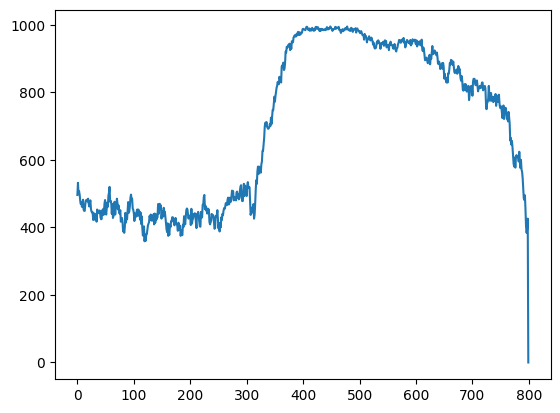

In [56]:
plt.plot(sig_lip_id_in)

In [69]:
str(np.where(sig_lip_id_out>threshold)[0]-275)

'['

In [66]:

'out:' + str(np.where(sig_lip_id_out>threshold)[0][0]-275) +'ms'

IndexError: index 0 is out of bounds for axis 0 with size 0

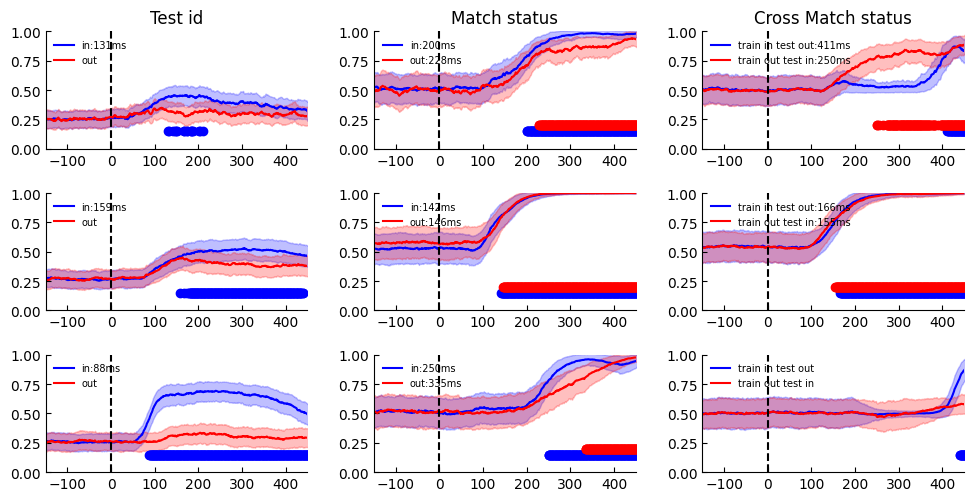

In [90]:

time_t=np.arange(start=-275, stop=525, step=1)
fig, ax=plt.subplots(3,3,figsize=(10,5))

fig.tight_layout()
threshold=990
ax[0,0]=plot_decoding(time=time_t,
                    data_av_in=np.mean(perf_decoding_lip['perf id in'], axis=0)/40,
                    data_av_out=np.mean(perf_decoding_lip['perf id out'], axis=0)/40,
                    data_std_in=np.std(perf_decoding_lip['perf id in'], axis=0)/40,
                    data_std_out=np.std(perf_decoding_lip['perf id out'], axis=0)/40,
                    sig_in=sig_lip_id_in,
                    sig_out=sig_lip_id_out,
                    threshold=threshold,
                    title='Test id',
                    label1='in:'+ str(np.where(sig_lip_id_in>threshold)[0][0]-275)+'ms',
                    label2='out',
                    ax=ax[0,0])

ax[0,1]=plot_decoding(time=   time_t,
                    data_av_in=np.mean(perf_decoding_lip['perf match in'], axis=0)/20,
                    data_av_out=np.mean(perf_decoding_lip['perf match out'], axis=0)/20,
                    data_std_in=np.std(perf_decoding_lip['perf match in'], axis=0)/20,
                    data_std_out=np.std(perf_decoding_lip['perf match out'], axis=0)/20,
                    sig_in=sig_lip_match_in,
                    sig_out=sig_lip_match_out,
                    threshold=threshold,
                    title='Match status',
                    label1='in:'+ str(np.where(sig_lip_match_in>threshold)[0][0]-275)+'ms',
                    label2='out:'+ str(np.where(sig_lip_match_out>threshold)[0][0]-275)+'ms',
                    ax=ax[0,1])


ax[0,2]=plot_decoding(time=   time_t,
                    data_av_in=np.mean(perf_decoding_lip['perf xmatch inout'], axis=0)/20,
                    data_av_out=np.mean(perf_decoding_lip['perf xmatch outin'], axis=0)/20,
                    data_std_in=np.std(perf_decoding_lip['perf xmatch inout'], axis=0)/20,
                    data_std_out=np.std(perf_decoding_lip['perf xmatch outin'], axis=0)/20,
                    sig_in=sig_lip_xmatch_inout,
                    sig_out=sig_lip_xmatch_outin,
                    threshold=threshold,
                    label1='train in test out:'+ str(np.where(sig_lip_xmatch_inout>threshold)[0][0]-275)+'ms',
                    label2='train out test in:'+ str(np.where(sig_lip_xmatch_outin>threshold)[0][0]-275)+'ms',
                    title='Cross Match status',
                    ax=ax[0,2])



ax[1,0]=plot_decoding(time=time_t,
                    data_av_in=np.mean(perf_decoding_pfc['perf id in'], axis=0)/40,
                    data_av_out=np.mean(perf_decoding_pfc['perf id out'], axis=0)/40,
                    data_std_in=np.std(perf_decoding_pfc['perf id in'], axis=0)/40,
                    data_std_out=np.std(perf_decoding_pfc['perf id out'], axis=0)/40,
                    sig_in=sig_pfc_id_in,
                    sig_out=sig_pfc_id_out,
                    threshold=threshold,
                    title='',
                    label1='in:'+ str(np.where(sig_pfc_id_in>threshold)[0][0]-275)+'ms',
                    label2='out',
                    ax=ax[1,0])

ax[1,1]=plot_decoding(time=   time_t,
                    data_av_in=np.mean(perf_decoding_pfc['perf match in'], axis=0)/20,
                    data_av_out=np.mean(perf_decoding_pfc['perf match out'], axis=0)/20,
                    data_std_in=np.std(perf_decoding_pfc['perf match in'], axis=0)/20,
                    data_std_out=np.std(perf_decoding_pfc['perf match out'], axis=0)/20,
                    sig_in=sig_pfc_match_in,
                    sig_out=sig_pfc_match_out,
                    threshold=threshold,
                    title='',
                    label1='in:'+ str(np.where(sig_pfc_match_in>threshold)[0][0]-275)+'ms',
                    label2='out:'+ str(np.where(sig_pfc_match_out>threshold)[0][0]-275)+'ms',
                    ax=ax[1,1])


ax[1,2]=plot_decoding(time=   time_t,
                    data_av_in=np.mean(perf_decoding_pfc['perf xmatch inout'], axis=0)/20,
                    data_av_out=np.mean(perf_decoding_pfc['perf xmatch outin'], axis=0)/20,
                    data_std_in=np.std(perf_decoding_pfc['perf xmatch inout'], axis=0)/20,
                    data_std_out=np.std(perf_decoding_pfc['perf xmatch outin'], axis=0)/20,
                    sig_in=sig_pfc_xmatch_inout,
                    sig_out=sig_pfc_xmatch_outin,
                    threshold=threshold,
                    label1='train in test out:'+ str(np.where(sig_pfc_xmatch_inout>threshold)[0][0]-275)+'ms',
                    label2='train out test in:'+ str(np.where(sig_pfc_xmatch_outin>threshold)[0][0]-275)+'ms',
                    title='',
                    ax=ax[1,2])



ax[2,0]=plot_decoding(time=time_t,
                    data_av_in=np.mean(perf_decoding_v4['perf id in'], axis=0)/40,
                    data_av_out=np.mean(perf_decoding_v4['perf id out'], axis=0)/40,
                    data_std_in=np.std(perf_decoding_v4['perf id in'], axis=0)/40,
                    data_std_out=np.std(perf_decoding_v4['perf id out'], axis=0)/40,
                    sig_in=sig_v4_id_in,
                    sig_out=sig_v4_id_out,
                    threshold=threshold,
                    title='',
                    label1='in:'+ str(np.where(sig_v4_id_in>threshold)[0][0]-275)+'ms',
                    label2='out',
                    ax=ax[2,0])

ax[2,1]=plot_decoding(time=   time_t,
                    data_av_in=np.mean(perf_decoding_v4['perf match in'], axis=0)/20,
                    data_av_out=np.mean(perf_decoding_v4['perf match out'], axis=0)/20,
                    data_std_in=np.std(perf_decoding_v4['perf match in'], axis=0)/20,
                    data_std_out=np.std(perf_decoding_v4['perf match out'], axis=0)/20,
                    sig_in=sig_v4_match_in,
                    sig_out=sig_v4_match_out,
                    threshold=threshold,
                    title='',
                    label1='in:'+ str(np.where(sig_v4_match_in>threshold)[0][0]-275)+'ms',
                    label2='out:'+ str(np.where(sig_v4_match_out>threshold)[0][0]-275)+'ms',
                    ax=ax[2,1])


ax[2,2]=plot_decoding(time=   time_t,
                    data_av_in=np.mean(perf_decoding_v4['perf xmatch inout'], axis=0)/20,
                    data_av_out=np.mean(perf_decoding_v4['perf xmatch outin'], axis=0)/20,
                    data_std_in=np.std(perf_decoding_v4['perf xmatch inout'], axis=0)/20,
                    data_std_out=np.std(perf_decoding_v4['perf xmatch outin'], axis=0)/20,
                    sig_in=sig_v4_xmatch_inout,
                    sig_out=sig_v4_xmatch_outin,
                    threshold=threshold,
                    label1='train in test out',
                    label2='train out test in',
                    title='',
                    ax=ax[2,2])

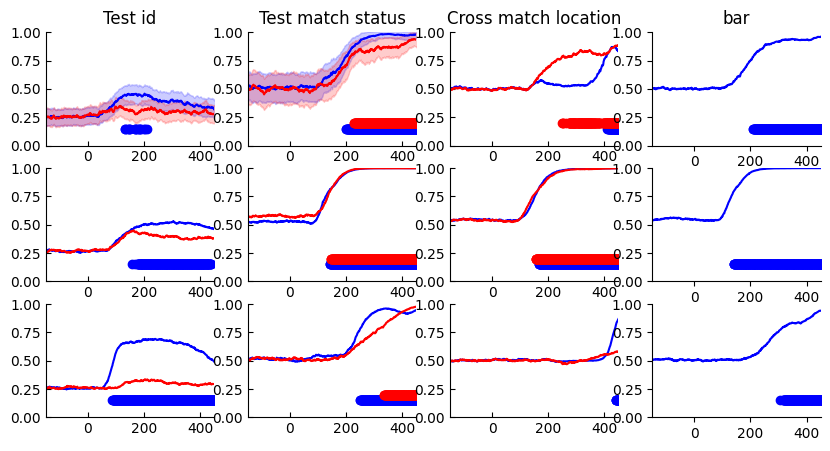

In [15]:


fig, ax=plt.subplots(3,4,figsize=(10,5))

av=np.mean(perf_decoding_lip['perf id in'], axis=0)/40
st=np.std(perf_decoding_lip['perf id in'], axis=0)/40
ax[0,0].plot(time_t,av, color='b')
ax[0,0].fill_between(time_t,av-st, av+st, color='b', alpha=.2)
ax[0,0].scatter(time_t[np.where(sig_lip_id_in>990)[0]], np.zeros(time_t[np.where(sig_lip_id_in>990)[0]].shape[0])+0.15, color='b')

av=np.mean(perf_decoding_lip['perf id out'], axis=0)/40
st=np.std(perf_decoding_lip['perf id out'], axis=0)/40
ax[0,0].plot(time_t,av, color='r')
ax[0,0].fill_between(time_t,av-st, av+st, color='r', alpha=.2)
ax[0,0].scatter(time_t[np.where(sig_lip_id_out>990)[0]], np.zeros(time_t[np.where(sig_lip_id_out>990)[0]].shape[0])+0.2, color='r')
ax[0,0].legend('in')

av=np.mean(perf_decoding_lip['perf match in'], axis=0)/20
st=np.std(perf_decoding_lip['perf match in'], axis=0)/20
ax[0,1].plot(time_t,av, color='b')
ax[0,1].fill_between(time_t,av-st, av+st, color='b', alpha=.2)
ax[0,1].scatter(time_t[np.where(sig_lip_match_in>990)[0]], np.zeros(time_t[np.where(sig_lip_match_in>990)[0]].shape[0])+0.15, color='b')

av=np.mean(perf_decoding_lip['perf match out'], axis=0)/20
st=np.std(perf_decoding_lip['perf match out'], axis=0)/20
ax[0,1].plot(time_t,av, color='r')
ax[0,1].fill_between(time_t,av-st, av+st, color='r', alpha=.2)
ax[0,1].scatter(time_t[np.where(sig_lip_match_out>990)[0]], np.zeros(time_t[np.where(sig_lip_match_out>990)[0]].shape[0])+0.2, color='r')


ax[0,2].plot(time_t,np.mean(perf_decoding_lip['perf xmatch inout'], axis=0)/20, color='b')
ax[0,2].scatter(time_t[np.where(sig_lip_xmatch_inout>990)[0]], np.zeros(time_t[np.where(sig_lip_xmatch_inout>990)[0]].shape[0])+0.15, color='b')
ax[0,2].plot(time_t,np.mean(perf_decoding_lip['perf xmatch outin'], axis=0)/20, color='r')
ax[0,2].scatter(time_t[np.where(sig_lip_xmatch_outin>990)[0]], np.zeros(time_t[np.where(sig_lip_xmatch_outin>990)[0]].shape[0])+0.2, color='r')

ax[0,3].plot(time_t,np.mean(perf_decoding_lip['perf bar'], axis=0)/20, color='b')
ax[0,3].scatter(time_t[np.where(sig_lip_bar>990)[0]], np.zeros(time_t[np.where(sig_lip_bar>990)[0]].shape[0])+0.15, color='b')




ax[1,0].plot(time_t,np.mean(perf_decoding_pfc['perf id in'], axis=0)/40, color='b')
ax[1,0].scatter(time_t[np.where(sig_pfc_id_in>990)[0]], np.zeros(time_t[np.where(sig_pfc_id_in>990)[0]].shape[0])+0.15, color='b')
ax[1,0].plot(time_t,np.mean(perf_decoding_pfc['perf id out'], axis=0)/40, color='r')
ax[1,0].scatter(time_t[np.where(sig_pfc_id_out>990)[0]], np.zeros(time_t[np.where(sig_pfc_id_out>990)[0]].shape[0])+0.2, color='r')


ax[1,1].plot(time_t,np.mean(perf_decoding_pfc['perf match in'], axis=0)/20, color='b')
ax[1,1].scatter(time_t[np.where(sig_pfc_match_in>990)[0]], np.zeros(time_t[np.where(sig_pfc_match_in>990)[0]].shape[0])+0.15, color='b')
ax[1,1].plot(time_t,np.mean(perf_decoding_pfc['perf match out'], axis=0)/20, color='r')
ax[1,1].scatter(time_t[np.where(sig_pfc_match_out>990)[0]], np.zeros(time_t[np.where(sig_pfc_match_out>990)[0]].shape[0])+0.2, color='r')


ax[1,2].plot(time_t,np.mean(perf_decoding_pfc['perf xmatch inout'], axis=0)/20, color='b')
ax[1,2].scatter(time_t[np.where(sig_pfc_xmatch_inout>990)[0]], np.zeros(time_t[np.where(sig_pfc_xmatch_inout>990)[0]].shape[0])+0.15, color='b')
ax[1,2].plot(time_t,np.mean(perf_decoding_pfc['perf xmatch outin'], axis=0)/20, color='r')
ax[1,2].scatter(time_t[np.where(sig_pfc_xmatch_outin>990)[0]], np.zeros(time_t[np.where(sig_pfc_xmatch_outin>990)[0]].shape[0])+0.2, color='r')

ax[1,3].plot(time_t,np.mean(perf_decoding_pfc['perf bar'], axis=0)/20, color='b')
ax[1,3].scatter(time_t[np.where(sig_pfc_bar>990)[0]], np.zeros(time_t[np.where(sig_pfc_bar>990)[0]].shape[0])+0.15, color='b')




ax[2,0].plot(time_t,np.mean(perf_decoding_v4['perf id in'], axis=0)/40, color='b')
ax[2,0].scatter(time_t[np.where(sig_v4_id_in>990)[0]], np.zeros(time_t[np.where(sig_v4_id_in>990)[0]].shape[0])+0.15, color='b')
ax[2,0].plot(time_t,np.mean(perf_decoding_v4['perf id out'], axis=0)/40, color='r')
ax[2,0].scatter(time_t[np.where(sig_v4_id_out>990)[0]], np.zeros(time_t[np.where(sig_v4_id_out>990)[0]].shape[0])+0.2, color='r')


ax[2,1].plot(time_t,np.mean(perf_decoding_v4['perf match in'], axis=0)/20, color='b')
ax[2,1].scatter(time_t[np.where(sig_v4_match_in>990)[0]], np.zeros(time_t[np.where(sig_v4_match_in>990)[0]].shape[0])+0.15, color='b')
ax[2,1].plot(time_t,np.mean(perf_decoding_v4['perf match out'], axis=0)/20, color='r')
ax[2,1].scatter(time_t[np.where(sig_v4_match_out>990)[0]], np.zeros(time_t[np.where(sig_v4_match_out>990)[0]].shape[0])+0.2, color='r')


ax[2,2].plot(time_t,np.mean(perf_decoding_v4['perf xmatch inout'], axis=0)/20, color='b')
ax[2,2].scatter(time_t[np.where(sig_v4_xmatch_inout>990)[0]], np.zeros(time_t[np.where(sig_v4_xmatch_inout>990)[0]].shape[0])+0.15, color='b')
ax[2,2].plot(time_t,np.mean(perf_decoding_v4['perf xmatch outin'], axis=0)/20, color='r')
ax[2,2].scatter(time_t[np.where(sig_v4_xmatch_outin>990)[0]], np.zeros(time_t[np.where(sig_v4_xmatch_outin>990)[0]].shape[0])+0.2, color='r')

ax[2,3].plot(time_t,np.mean(perf_decoding_v4['perf bar'], axis=0)/20, color='b')
ax[2,3].scatter(time_t[np.where(sig_v4_bar>990)[0]], np.zeros(time_t[np.where(sig_v4_bar>990)[0]].shape[0])+0.15, color='b')





ax[0,0].set_xlim([-150, 450])
ax[0,1].set_xlim([-150, 450])
ax[0,2].set_xlim([-150, 450])
ax[0,3].set_xlim([-150, 450])
ax[1,0].set_xlim([-150, 450])
ax[1,1].set_xlim([-150, 450])
ax[1,2].set_xlim([-150, 450])
ax[1,3].set_xlim([-150, 450])
ax[2,0].set_xlim([-150, 450])
ax[2,1].set_xlim([-150, 450])
ax[2,2].set_xlim([-150, 450])
ax[2,3].set_xlim([-150, 450])

ax[0,0].set_ylim([0,1])
ax[0,1].set_ylim([0,1])
ax[0,2].set_ylim([0,1])
ax[0,3].set_ylim([0,1])
ax[1,0].set_ylim([0,1])
ax[1,1].set_ylim([0,1])
ax[1,2].set_ylim([0,1])
ax[1,3].set_ylim([0,1])
ax[2,0].set_ylim([0,1])
ax[2,1].set_ylim([0,1])
ax[2,2].set_ylim([0,1])
ax[2,3].set_ylim([0,1])


ax[0,0].tick_params(direction="in")
ax[0,1].tick_params(direction="in")
ax[0,2].tick_params(direction="in")
ax[1,0].tick_params(direction="in")
ax[1,1].tick_params(direction="in")
ax[1,2].tick_params(direction="in")
ax[2,0].tick_params(direction="in")
ax[2,1].tick_params(direction="in")
ax[2,2].tick_params(direction="in")

ax[0,0].set_title('Test id')
ax[0,1].set_title('Test match status')
ax[0,2].set_title('Cross match location')
ax[0,3].set_title('bar')

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)

ax[0,2].spines['top'].set_visible(False)
ax[0,2].spines['right'].set_visible(False)
ax[0,3].spines['top'].set_visible(False)
ax[0,3].spines['right'].set_visible(False)


ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)

ax[1,2].spines['top'].set_visible(False)
ax[1,2].spines['right'].set_visible(False)
ax[1,3].spines['top'].set_visible(False)
ax[1,3].spines['right'].set_visible(False)

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)

ax[2,2].spines['top'].set_visible(False)
ax[2,2].spines['right'].set_visible(False)
ax[2,3].spines['top'].set_visible(False)
ax[2,3].spines['right'].set_visible(False)
